In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import requests
import os
import scipy.signal
import scipy.stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.model_selection import KFold
from dateutil.relativedelta import relativedelta
import time
from dateutil.tz import gettz
from datetime import timedelta
import calendar
import datetime
# from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
# import xgboost as xgb
%matplotlib inline
pd.set_option('display.max_rows', 50000)
pd.set_option('display.max_columns', 50000)




In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def gof(x,y,step):
    lgof = np.absolute(np.sum((y-x)**2/x))
    if lgof> chi[step-2]:
        lgof=1
    else:
        lgof= 0
    return lgof

def actpwr(x,y):
    diff = np.absolute(np.mean(y)-np.mean(x))
    
    return diff

# chi = [6.63,9.21,11.3,13.3,15.1,16.8,18.5,20.1,21.7,23.2,24.7,26.2,27.7,29.1,30.6,32,33.4,34.8,36.2,37.6,38.9,40.3,41.6,43,44.3,45.6,47,48.3,49.6,61.098, 62.487, 63.87, 65.247, 66.619, 67.985, 69.346, 70.703, 72.055, 73.402, 74.745, 76.084, 77.419, 78.75, 80.077, 81.4, 82.72, 84.037, 85.351, 86.661, 87.968, 89.272, 90.573, 91.872, 93.168, 94.461, 95.751, 97.039, 98.324, 99.607]
chi = [6.635,9.21,11.345,13.277,15.086,16.812,18.475,20.09,21.666,23.209,24.725,26.217,27.688,29.141,30.578,32,33.409,34.805,36.191,37.566,38.932,40.289,41.638,42.98,44.314,45.642,46.963,48.278,49.588,50.892,52.191,53.486,54.776,56.061,57.342,58.619,59.893,61.162,62.428,63.691,64.95,66.206,67.459,68.71,69.957,71.201,72.443,73.683,74.919,76.154,77.386,78.616,79.843,81.069,82.292,83.513,84.733,85.95,87.166,88.379,89.591,90.802,92.01,93.217,94.422,95.626,96.828,98.028,99.228,100.425,101.621,102.816,104.01,105.202,106.393,107.583,108.771,109.958,111.144,112.329,113.512,114.695,115.876,117.057,118.236,119.414,120.591,121.767,122.942,124.116,125.289,126.462,127.633,128.803,129.973,131.141,132.309,133.476,134.642,135.807,136.971,138.134,139.297,140.459,141.62,142.78,143.94,145.099,146.257,147.414,148.571,149.727,150.882,152.037,153.191,154.344,155.496,156.648,157.8,158.95,160.1,161.25,162.398,163.546,164.694,165.841,166.987,168.133,169.278,170.423,171.567,172.711,173.854,174.996,176.138,177.28,178.421,179.561,180.701,181.84,182.979,184.118,185.256,186.393,187.53,188.666,189.802,190.938,192.073,193.208,194.342,195.476,196.609,197.742,198.874,200.006,201.138,202.269,203.4,204.53,205.66,206.79,207.919,209.047,210.176,211.304,212.431,213.558,214.685,215.812,216.938,218.063,219.189,220.314,221.438,222.563,223.687,224.81,225.933,227.056,228.179,229.301,230.423,231.544,232.665,233.786,234.907,236.027,237.147,238.266,239.386,240.505,241.623,242.742,243.86,244.977,246.095,247.212,248.329,249.445
]

step = 50

In [64]:
def read_data(devid, acc_token, address, start_time, end_time, descriptors):


    r2 = requests.get(
        url=address + "/api/plugins/telemetry/DEVICE/" + devid + "/values/timeseries?keys=" + descriptors + "&startTs=" + start_time + "&endTs=" + end_time + "&agg=NONE&limit=1000000",
        headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()
    if r2:
        df = pd.DataFrame([])

        for desc in r2.keys():
            df1 = pd.DataFrame(r2[desc])
            df1.set_index('ts', inplace=True)
            df1.columns = [str(desc)]
            df = pd.concat([df, df1], axis=1)

        
        if df.empty == False:

            df.reset_index(drop=False, inplace=True)
            df = df.sort_values(by=['ts'])
            df.reset_index(drop=True, inplace=True)
            df.set_index('ts', inplace=True, drop=True)
            for col in df.columns:
                df[col] = df[col].astype('float')

            df = df.groupby(df.index).max()
            
        else:
            df = pd.DataFrame([])
    else:
        df = pd.DataFrame([])
        print('Empty json!')
    return df


In [7]:
## Read data per day
df = pd.read_csv('house_data/data_day_2.csv')
df['ts'] = pd.to_datetime(df['ts'],utc=True, unit='ms')
df.set_index('ts',inplace=True, drop=True)
# df.drop('ts',axis=1, inplace=True)
df = df.resample('20ms').max()
# df.dropna(inplace=True)
df['ts'] = df.index
df['ts'] = df['ts'].dt.tz_convert('Europe/Athens')
df.set_index('ts',inplace=True, drop=True)

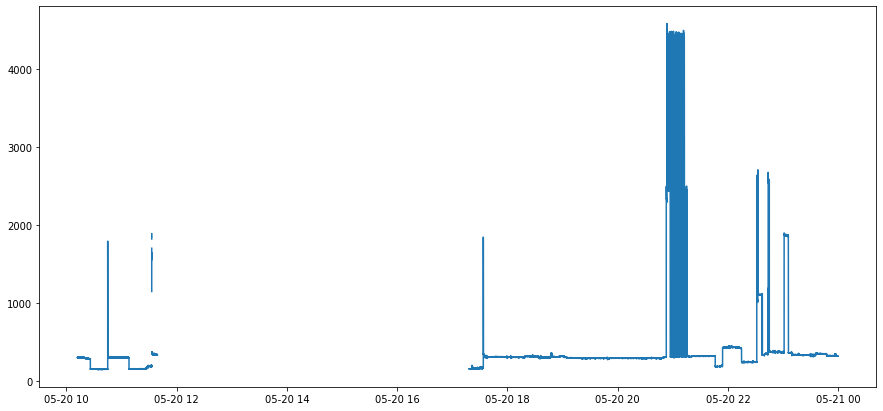

In [8]:
fig = plt.figure(figsize=[15,7])
plt.plot(df.index,df['pwrA'])

In [41]:
df2 = df['2020-05-19 02:38:53+03:00':'2020-05-19 04:00:00+03:00'].copy()
# fig = plt.figure(figsize=[15,7])
# plt.plot(df2.index,df2['pwrB'])
df2 = df2.reset_index(drop=False)
df2['label']=0
df2['label'].iloc[992:235943]=1
df2 = df2[['ts','pwrB','apwrB','rpwrB','label']]

df2.set_index('ts', inplace=True, drop=True)

for col in ['pwrB','apwrB','rpwrB']:
    df2[col] = df2[col] - np.mean(df2[col].iloc[:990])

df2.loc[df2['pwrB']<0,'pwrB']=0

df2.to_csv('plug_data/dish.csv')

In [9]:
## Read data per day
df = pd.read_csv('house_data/data_day_3.csv')
df['ts'] = pd.to_datetime(df['ts'],utc=True, unit='ms')
df.set_index('ts',inplace=True, drop=True)
# df.drop('ts',axis=1, inplace=True)
df = df.resample('20ms').max()
# df.dropna(inplace=True)
df['ts'] = df.index
df['ts'] = df['ts'].dt.tz_convert('Europe/Athens')
df.set_index('ts',inplace=True, drop=True)


In [10]:
####################
df2 = df['2020-05-21 02:10:00+03:00':'2020-05-21 03:40:00+03:00'].copy()
df2 = df2.reset_index(drop=False)
df2['label']=0
df2['label'].iloc[6396:257792]=1
df2 = df2[['ts','pwrB','apwrB','rpwrB','label']]

df2.set_index('ts', inplace=True, drop=True)

for col in ['pwrB','apwrB','rpwrB']:
    df2[col] = df2[col] - np.mean(df2[col].iloc[:6394])

df2.loc[df2['pwrB']<0,'pwrB']=0

df2.to_csv('plug_data/dish2.csv')


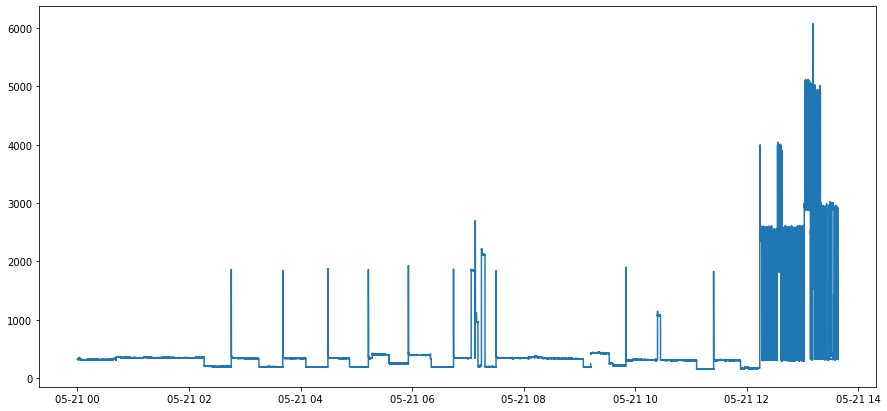

In [12]:
# df2 = df['2020-05-21 02:10:00+03:00':'2020-05-21 03:36:30+03:00'].copy()
fig = plt.figure(figsize=[15,7])
plt.plot(df.index,df['pwrA'])

In [11]:
## Read data for washing machine
df = pd.read_csv('house_data/data_day_0_0.csv')
df['ts'] = pd.to_datetime(df['ts'],utc=True, unit='ms')
df.set_index('ts',inplace=True, drop=True)
# df.drop('ts',axis=1, inplace=True)
df = df.resample('20ms').max()
# df.dropna(inplace=True)
df['ts'] = df.index
df['ts'] = df['ts'].dt.tz_convert('Europe/Athens')
df.set_index('ts',inplace=True, drop=True)

In [13]:

df2 = df['2020-05-18 15:20:00+03:00':'2020-05-18 17:19:00+03:00'].copy()
df2 = df2.reset_index(drop=False)

df2['label']=0
df2['label'].iloc[18704:]=1
df2 = df2[['ts','pwrA','apwrA','rpwrA','label']]

df2.set_index('ts', inplace=True, drop=True)

for col in ['pwrA','apwrA','rpwrA']:
    df2[col] = df2[col] - np.mean(df2[col].iloc[:18704])

df2.loc[df2['pwrA']<0,'pwrA']=0

df2.to_csv('plug_data/wash.csv')

In [29]:
## Read data for fridge 
df = pd.read_csv('house_data/data_day_4.csv')
df['ts'] = pd.to_datetime(df['ts'],utc=True, unit='ms')
df['ts'] = df['ts'].dt.tz_convert('Europe/Athens')

df.set_index('ts',inplace=True, drop=True)
df = df['2020-05-22 23:01:00+03:00':]

df1 = pd.read_csv('house_data/data_day_5.csv')
df1['ts'] = pd.to_datetime(df1['ts'],utc=True, unit='ms')
df1['ts'] = df1['ts'].dt.tz_convert('Europe/Athens')

df1.set_index('ts',inplace=True, drop=True)

df = pd.concat([df,df1],axis=0)
df = df[:'2020-05-23 01:25:00+03:00']

df1 = df1['2020-05-23 15:00:00+03:00':'2020-05-23 17:42:00+03:00']


# df.drop('ts',axis=1, inplace=True)
df = df.resample('20ms').max()
df = df.reset_index(drop=False)
df['label']=0
df = df[['ts','pwrA','apwrA','rpwrA','label']]
df.set_index('ts', inplace=True, drop=True)

for col in ['pwrA','apwrA','rpwrA']:
    df[col] = df[col] - np.mean(df[col].iloc[:20])

df.loc[df['pwrA']>20,'label']=1

    
df.loc[df['pwrA']<0,'pwrA']=0

# df.dropna(inplace=True)
df1 = df1.resample('20ms').max()
df1 = df1.reset_index(drop=False)
df1['label']=0
df1 = df1[['ts','pwrA','apwrA','rpwrA','label']]
df1.set_index('ts', inplace=True, drop=True)

for col in ['pwrA','apwrA','rpwrA']:
    df1[col] = df1[col] - np.mean(df1[col].iloc[:20])

df1.loc[df1['pwrA']>20,'label']=1


df1.loc[df1['pwrA']<0,'pwrA']=0



df = pd.concat([df,df1])
df.to_csv('plug_data/fridge.csv')

In [61]:
## Read data for heat pump 
df = pd.read_csv('../../Desktop/windowsshare/stelios_data/house_data/data_day_6.csv')
df['ts'] = pd.to_datetime(df['ts'],utc=True, unit='ms')
df['ts'] = df['ts'].dt.tz_convert('Europe/Athens')
df.set_index('ts',inplace=True, drop=True)
df = df.resample('20ms').max()

df.loc[df['pwrC']<0, 'pwrC']=0

In [62]:
df2 = df['2020-05-24 06:00:00+03:00':'2020-05-24 06:29:00+03:00']
df2 = df2.reset_index(drop=False)

df2['label']=0
df2 = df2[['ts','pwrC','apwrC','rpwrC','label']]

df2.set_index('ts', inplace=True, drop=True)

for col in ['pwrC','apwrC','rpwrC']:
    df2[col] = df2[col] - np.mean(df2[col].iloc[:500])
    
df2.loc[df2['pwrC']>20,'label']=1

df2.to_csv('../../Desktop/windowsshare/stelios_data/plug_data/heatpumpC.csv')

In [63]:
## Read data for heat pump B
df = pd.read_csv('../../Desktop/windowsshare/stelios_data/house_data/data_day_7.csv')
df['ts'] = pd.to_datetime(df['ts'],utc=True, unit='ms')
df['ts'] = df['ts'].dt.tz_convert('Europe/Athens')
df.set_index('ts',inplace=True, drop=True)
df = df.resample('20ms').max()

# df.loc[df['pwrC']<0, 'pwrC']=0

In [64]:
df2 = df['2020-05-25 07:18:30+03:00':'2020-05-25 07:39:00+03:00']

df2 = df2.reset_index(drop=False)

df2['label']=0
df2 = df2[['ts','pwrB','apwrB','rpwrB','label']]

df2.set_index('ts', inplace=True, drop=True)

for col in ['pwrB','apwrB','rpwrB']:
    df2[col] = df2[col] - np.mean(df2[col].iloc[:100])
    
df2.loc[df2['pwrB']>20,'label']=1

df2.to_csv('../../Desktop/windowsshare/stelios_data/plug_data/heatpumpB.csv')



In [67]:
## Read data for heat pump B
df = pd.read_csv('../../Desktop/windowsshare/stelios_data/house_data/data_day_7.csv')
df['ts'] = pd.to_datetime(df['ts'],utc=True, unit='ms')
df['ts'] = df['ts'].dt.tz_convert('Europe/Athens')
df.set_index('ts',inplace=True, drop=True)
df = df.resample('20ms').max()


In [75]:
df2 = df['2020-05-25 08:11:30+03:00':'2020-05-25 08:27:00+03:00']
df2 = df2.reset_index(drop=False)

df2['label']=0
df2 = df2[['ts','pwrA','apwrA','rpwrA','label']]

df2.set_index('ts', inplace=True, drop=True)

for col in ['pwrA','apwrA','rpwrA']:
    df2[col] = df2[col] - np.mean(df2[col].iloc[:100])
    
df2.loc[df2['pwrA']>50,'label']=1

df2.to_csv('../../Desktop/windowsshare/stelios_data/plug_data/heatpumpA.csv')


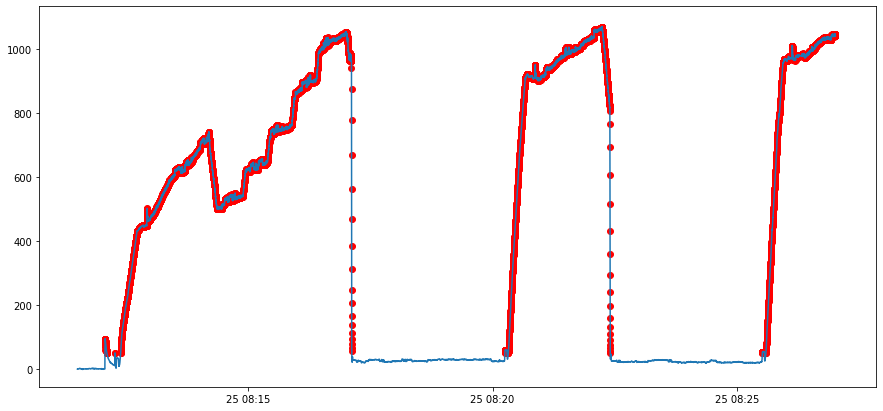

In [74]:

fig = plt.figure(figsize=[15,7])
plt.plot(df2.index,df2['pwrA'])


cl = df2['label']==1

plt.scatter(df2.index[cl], df2['pwrA'][cl], color='red') 

In [4]:
## Read data for heat stove and oven
df = pd.read_csv('../../Desktop/windowsshare/stelios_data/house_data/data_day_8.csv')
df['ts'] = pd.to_datetime(df['ts'],utc=True, unit='ms')
df['ts'] = df['ts'].dt.tz_convert('Europe/Athens')
df.set_index('ts',inplace=True, drop=True)
df = df.resample('20ms').max()



In [20]:
df1 = df['2020-05-26 13:02:00+03:00':'2020-05-26 13:03:00+03:00']
df2 = df['2020-05-26 13:20:30+03:00':'2020-05-26 14:10:00+03:00']
df2 = df2.reset_index(drop=False)

df2['label']=0
df2 = df2[['ts','pwrA','apwrA','rpwrA','label']]

df2.set_index('ts', inplace=True, drop=True)

for col in ['pwrA','apwrA','rpwrA']:
    df2[col] = df2[col] - np.mean(df1[col])
    
df2.loc[df2['pwrA']>50,'label']=1

df2.to_csv('../../Desktop/windowsshare/stelios_data/plug_data/stove.csv')

In [21]:
df2 = df['2020-05-26 17:52:00+03:00':'2020-05-26 18:12:00+03:00']
df2 = df2.reset_index(drop=False)

df2['label']=0
df2 = df2[['ts','pwrA','apwrA','rpwrA','label']]

df2.set_index('ts', inplace=True, drop=True)

for col in ['pwrA','apwrA','rpwrA']:
    df2[col] = df2[col] - np.mean(df2[col].iloc[:100])
    
df2.loc[df2['pwrA']>50,'label']=1

df2.to_csv('../../Desktop/windowsshare/stelios_data/plug_data/oven.csv')

In [23]:
## Read data for entilator and vacuum
df = pd.read_csv('../../Desktop/windowsshare/stelios_data/house_data/data_day_9.csv')
df['ts'] = pd.to_datetime(df['ts'],utc=True, unit='ms')
df['ts'] = df['ts'].dt.tz_convert('Europe/Athens')
df.set_index('ts',inplace=True, drop=True)
df = df.resample('20ms').max()

In [24]:
df2 = df['2020-05-27 11:38:00+03:00':'2020-05-27 11:46:00+03:00']
df2 = df2.reset_index(drop=False)

df2['label']=0
df2 = df2[['ts','pwrA','apwrA','rpwrA','label']]

df2.set_index('ts', inplace=True, drop=True)

for col in ['pwrA','apwrA','rpwrA']:
    df2[col] = df2[col] - np.mean(df2[col].iloc[:100])
    
df2.loc[df2['pwrA']>30,'label']=1

df2.to_csv('../../Desktop/windowsshare/stelios_data/plug_data/entilator.csv')

In [27]:
df2 = df['2020-05-27 11:51:00+03:00':'2020-05-27 12:03:00+03:00']
df2 = df2.reset_index(drop=False)

df2['label']=0
df2 = df2[['ts','pwrA','apwrA','rpwrA','label']]

df2.set_index('ts', inplace=True, drop=True)

for col in ['pwrA','apwrA','rpwrA']:
    df2[col] = df2[col] - np.mean(df2[col].iloc[:100])
    
df2.loc[df2['pwrA']>30,'label']=1

df2.to_csv('../../Desktop/windowsshare/stelios_data/plug_data/vacuum.csv')

In [3]:
# Read again data for heatpump
devid = '4353f360-98d6-11ea-8d54-4d0d5d00237b'
descriptors = 'pwrA,pwrB,pwrC,rpwrA,rpwrB,rpwrC,apwrA,apwrB,apwrC'
start_time = '1590870221000'
end_time = '1590871620000'


address = "http://52.77.235.183:8080"

r = requests.post(address + "/api/auth/login",
                  json={'username': 'tenant@thingsboard.org', 'password': 'tenant'}).json()

acc_token = 'Bearer' + ' ' + r['token']

#     df = read_data(devid, acc_token, address, str(start_time[i]), str(end_time[i]), descriptors)  

r2 = requests.get(
    url=address + "/api/plugins/telemetry/DEVICE/" + devid + "/values/timeseries?keys=" + descriptors + "&startTs=" + start_time + "&endTs=" + end_time + "&agg=NONE&limit=1000000",
    headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()

if r2:
    df = pd.DataFrame([])

    for desc in r2.keys():
        df1 = pd.DataFrame(r2[desc])
        df1.set_index('ts', inplace=True)
        df1.columns = [str(desc)]
        df = pd.concat([df, df1], axis=1)


    if df.empty == False:

        df.reset_index(drop=False, inplace=True)
        df = df.sort_values(by=['ts'])
        df.reset_index(drop=True, inplace=True)
        df.set_index('ts', inplace=True, drop=True)
        for col in df.columns:
            df[col] = df[col].astype('float')

        df = df.groupby(df.index).max()
        
df['ts'] = pd.to_datetime(df.index,utc=True, unit='ms')
df['ts'] = df['ts'].dt.tz_convert('Europe/Athens')

df.set_index('ts',inplace=True, drop=True)


,pwrA,pwrB,pwrC,rpwrA,rpwrB,rpwrC,apwrA,apwrB,apwrC
ts,,,,,,,,,
2020-05-30 23:23:41.009000+03:00,332.2444,210.0263,72.1718,89.2529,104.7713,-130.2297,344.0997,229.8236,144.1289
2020-05-30 23:23:41.029000+03:00,332.2774,210.2740,72.1387,89.2456,104.0658,-130.4857,344.0666,229.9722,144.1619
2020-05-30 23:23:41.049000+03:00,332.3105,210.4721,72.1057,89.6482,104.3995,-129.6521,344.0501,230.1043,144.1619
2020-05-30 23:23:41.069000+03:00,332.3765,210.6042,72.1057,88.4067,104.7226,-130.2408,344.0501,230.2694,144.1619
2020-05-30 23:23:41.089000+03:00,332.4921,210.7198,72.1222,88.8345,104.5450,-130.5550,344.0666,230.4345,144.1619


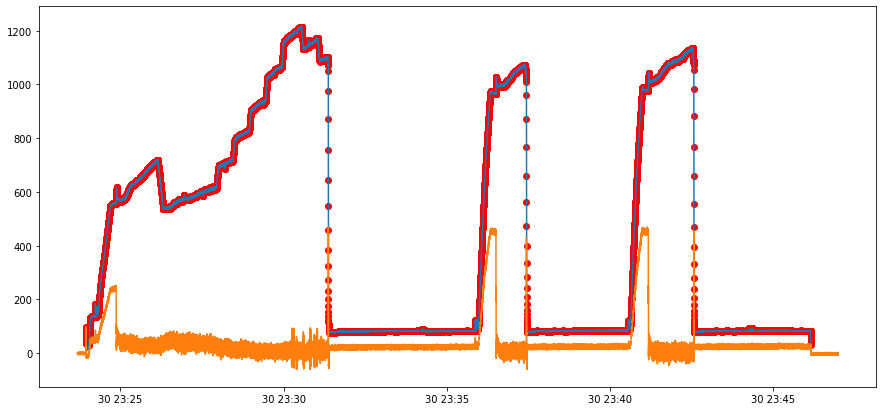

In [13]:
# df['pwrA'].plot()
# df2['pwrB'].plot()
# df['pwrC'].plot()

fig = plt.figure(figsize=[15,7])
plt.plot(df2.index,df2['pwrB'],df2.index,df2['rpwrB'])


cl = df2['label']==1

plt.scatter(df2.index[cl], df2['pwrB'][cl], color='red') 

In [17]:
df2 = df.copy()
df2 = df2.reset_index(drop=False)

df2['label']=0
df2 = df2[['ts','pwrB','apwrB','rpwrB','label']]

df2.set_index('ts', inplace=True, drop=True)

for col in ['pwrB','apwrB','rpwrB']:
    df2[col] = df2[col] - np.mean(df2[col].iloc[-20:])
    
df2.loc[df2['pwrB']>30,'label']=1
df2.to_csv('../../Desktop/windowsshare/stelios_data/plug_data/heatpumpB.csv')

In [25]:
df2 = df.copy()
df2 = df2.reset_index(drop=False)

df2['label']=0
df2 = df2[['ts','pwrA','apwrA','rpwrA','label']]

df2.set_index('ts', inplace=True, drop=True)

for col in ['pwrA','apwrA','rpwrA']:
    df2[col] = df2[col] - np.mean(df2[col].iloc[-20:])
    
df2.loc[df2['pwrA']>30,'label']=1
df2.to_csv('../../Desktop/windowsshare/stelios_data/plug_data/heatpumpA.csv')

In [29]:
df2 = df[:'2020-05-30 23:47:00+03:00']
df2 = df2.reset_index(drop=False)

df2['label']=0
df2 = df2[['ts','pwrC','apwrC','rpwrC','label']]

df2.set_index('ts', inplace=True, drop=True)

for col in ['pwrC','apwrC','rpwrC']:
    df2[col] = df2[col] - np.mean(df2[col].iloc[-20:])
    
df2.loc[df2['pwrC']>30,'label']=1
df2.to_csv('../../Desktop/windowsshare/stelios_data/plug_data/heatpumpC.csv')

In [7]:
# Read again data for iron
devid = '4353f360-98d6-11ea-8d54-4d0d5d00237b'
descriptors = 'pwrA,pwrB,pwrC,rpwrA,rpwrB,rpwrC,apwrA,apwrB,apwrC'
start_time = '1591734000000'
end_time = '1591734600000'


address = "http://52.77.235.183:8080"

r = requests.post(address + "/api/auth/login",
                  json={'username': 'tenant@thingsboard.org', 'password': 'tenant'}).json()

acc_token = 'Bearer' + ' ' + r['token']

#     df = read_data(devid, acc_token, address, str(start_time[i]), str(end_time[i]), descriptors)  

r2 = requests.get(
    url=address + "/api/plugins/telemetry/DEVICE/" + devid + "/values/timeseries?keys=" + descriptors + "&startTs=" + start_time + "&endTs=" + end_time + "&agg=NONE&limit=1000000",
    headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()

if r2:
    df = pd.DataFrame([])

    for desc in r2.keys():
        df1 = pd.DataFrame(r2[desc])
        df1.set_index('ts', inplace=True)
        df1.columns = [str(desc)]
        df = pd.concat([df, df1], axis=1)


    if df.empty == False:

        df.reset_index(drop=False, inplace=True)
        df = df.sort_values(by=['ts'])
        df.reset_index(drop=True, inplace=True)
        df.set_index('ts', inplace=True, drop=True)
        for col in df.columns:
            df[col] = df[col].astype('float')

        df = df.groupby(df.index).max()
        
df['ts'] = pd.to_datetime(df.index,utc=True, unit='ms')
df['ts'] = df['ts'].dt.tz_convert('Europe/Athens')

df.set_index('ts',inplace=True, drop=True)


In [9]:
df2 = df.copy()
df2 = df2.reset_index(drop=False)

df2['label']=0
df2 = df2[['ts','pwrC','apwrC','rpwrC','label']]

df2.set_index('ts', inplace=True, drop=True)

for col in ['pwrC','apwrC','rpwrC']:
    df2[col] = df2[col] - np.mean(df2[col].iloc[-20:])
    
df2.loc[df2['pwrC']>30,'label']=1
df2.to_csv('../../Desktop/windowsshare/stelios_data/plug_data/iron.csv')

In [11]:
# Read again data for iron press
devid = '4353f360-98d6-11ea-8d54-4d0d5d00237b'
descriptors = 'pwrA,pwrB,pwrC,rpwrA,rpwrB,rpwrC,apwrA,apwrB,apwrC'
start_time = '1591734900000'
end_time = '1591735575000'


address = "http://52.77.235.183:8080"

r = requests.post(address + "/api/auth/login",
                  json={'username': 'tenant@thingsboard.org', 'password': 'tenant'}).json()

acc_token = 'Bearer' + ' ' + r['token']

#     df = read_data(devid, acc_token, address, str(start_time[i]), str(end_time[i]), descriptors)  

r2 = requests.get(
    url=address + "/api/plugins/telemetry/DEVICE/" + devid + "/values/timeseries?keys=" + descriptors + "&startTs=" + start_time + "&endTs=" + end_time + "&agg=NONE&limit=1000000",
    headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()

if r2:
    df = pd.DataFrame([])

    for desc in r2.keys():
        df1 = pd.DataFrame(r2[desc])
        df1.set_index('ts', inplace=True)
        df1.columns = [str(desc)]
        df = pd.concat([df, df1], axis=1)


    if df.empty == False:

        df.reset_index(drop=False, inplace=True)
        df = df.sort_values(by=['ts'])
        df.reset_index(drop=True, inplace=True)
        df.set_index('ts', inplace=True, drop=True)
        for col in df.columns:
            df[col] = df[col].astype('float')

        df = df.groupby(df.index).max()
        
df['ts'] = pd.to_datetime(df.index,utc=True, unit='ms')
df['ts'] = df['ts'].dt.tz_convert('Europe/Athens')

df.set_index('ts',inplace=True, drop=True)


In [12]:
df2 = df.copy()
df2 = df2.reset_index(drop=False)

df2['label']=0
df2 = df2[['ts','pwrC','apwrC','rpwrC','label']]

df2.set_index('ts', inplace=True, drop=True)

for col in ['pwrC','apwrC','rpwrC']:
    df2[col] = df2[col] - np.mean(df2[col].iloc[-20:])
    
df2.loc[df2['pwrC']>30,'label']=1
df2.to_csv('../../Desktop/windowsshare/stelios_data/plug_data/ironpress.csv')

In [34]:
# Read again data for freezer
devid = '4353f360-98d6-11ea-8d54-4d0d5d00237b'
descriptors = 'pwrA,pwrB,pwrC,rpwrA,rpwrB,rpwrC,apwrA,apwrB,apwrC'

# first time slot
# start_time = '1591824780000'
# end_time = '1591827720000'

#second time slot
start_time = '1592777100000'
end_time = '1592784780000'


address = "http://52.77.235.183:8080"

r = requests.post(address + "/api/auth/login",
                  json={'username': 'tenant@thingsboard.org', 'password': 'tenant'}).json()

acc_token = 'Bearer' + ' ' + r['token']

#     df = read_data(devid, acc_token, address, str(start_time[i]), str(end_time[i]), descriptors)  

r2 = requests.get(
    url=address + "/api/plugins/telemetry/DEVICE/" + devid + "/values/timeseries?keys=" + descriptors + "&startTs=" + start_time + "&endTs=" + end_time + "&agg=NONE&limit=1000000",
    headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()

if r2:
    df = pd.DataFrame([])

    for desc in r2.keys():
        df1 = pd.DataFrame(r2[desc])
        df1.set_index('ts', inplace=True)
        df1.columns = [str(desc)]
        df = pd.concat([df, df1], axis=1)


    if df.empty == False:

        df.reset_index(drop=False, inplace=True)
        df = df.sort_values(by=['ts'])
        df.reset_index(drop=True, inplace=True)
        df.set_index('ts', inplace=True, drop=True)
        for col in df.columns:
            df[col] = df[col].astype('float')

        df = df.groupby(df.index).max()
        
df['ts'] = pd.to_datetime(df.index,utc=True, unit='ms')
df['ts'] = df['ts'].dt.tz_convert('Europe/Athens')

df.set_index('ts',inplace=True, drop=True)


In [33]:
# read first time slot

tmp = df['2020-06-11 00:50:00+03:00':'2020-06-11 00:55:00+03:00'].copy()
df2 = df.copy()
df2 = df2.reset_index(drop=False)

df2['label']=0
df2 = df2[['ts','pwrB','apwrB','rpwrB','label']]

df2.set_index('ts', inplace=True, drop=True)

for col in ['pwrB','apwrB','rpwrB']:
    df2[col] = df2[col] - np.mean(tmp[col])
    
df2.loc[df2['pwrB']>40,'label']=1
# df2.to_csv('../../Desktop/windowsshare/stelios_data/plug_data/freezer.csv')

In [35]:
# read second time slot

df3 = df['2020-06-22 01:05:00+03:00':'2020-06-22 01:39:00+03:00'].copy()
df3 = df3.reset_index(drop=False)

df1 = df['2020-06-22 01:54:00+03:00':'2020-06-22 03:13:00+03:00'].copy()
df1 = df1.reset_index(drop=False)
df3 = pd.concat([df1,df3])
df3.reset_index(inplace=True,drop=True)


df3['label']=0
df3 = df3[['ts','pwrB','apwrB','rpwrB','label']]

df3.set_index('ts', inplace=True, drop=True)
df3.sort_index(inplace=True)

for col in ['pwrB','apwrB','rpwrB']:
    df3[col] = df3[col] - np.mean(df2[col].iloc[:40])
    
df3.loc[df3['pwrB']>40,'label']=1
# df2.to_csv('../../Desktop/windowsshare/stelios_data/plug_data/freezer.csv')

In [36]:
df2 = pd.concat([df2,df3])
# df2.reset_index(inplace=True,drop=True)
df2.sort_index(inplace=True)
df2.reset_index(inplace=True)

In [37]:
df2.to_csv('../../Desktop/windowsshare/stelios_data/plug_data/freezer.csv')

In [2]:
# Read  data for coffee machine
devid = '4353f360-98d6-11ea-8d54-4d0d5d00237b'
descriptors = 'pwrB,rpwrB,apwrB'
start_time = '1592372460000'
end_time = '1592372690000'


address = "http://52.77.235.183:8080"

r = requests.post(address + "/api/auth/login",
                  json={'username': 'tenant@thingsboard.org', 'password': 'tenant'}).json()

acc_token = 'Bearer' + ' ' + r['token']

#     df = read_data(devid, acc_token, address, str(start_time[i]), str(end_time[i]), descriptors)  

r2 = requests.get(
    url=address + "/api/plugins/telemetry/DEVICE/" + devid + "/values/timeseries?keys=" + descriptors + "&startTs=" + start_time + "&endTs=" + end_time + "&agg=NONE&limit=1000000",
    headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()

if r2:
    df = pd.DataFrame([])

    for desc in r2.keys():
        df1 = pd.DataFrame(r2[desc])
        df1.set_index('ts', inplace=True)
        df1.columns = [str(desc)]
        df = pd.concat([df, df1], axis=1)


    if df.empty == False:

        df.reset_index(drop=False, inplace=True)
        df = df.sort_values(by=['ts'])
        df.reset_index(drop=True, inplace=True)
        df.set_index('ts', inplace=True, drop=True)
        for col in df.columns:
            df[col] = df[col].astype('float')

        df = df.groupby(df.index).max()
        
df['ts'] = pd.to_datetime(df.index,utc=True, unit='ms')
df['ts'] = df['ts'].dt.tz_convert('Europe/Athens')

df.set_index('ts',inplace=True, drop=True)


In [6]:
# tmp = df['2020-06-11 00:50:00+03:00':'2020-06-11 00:55:00+03:00'].copy()
df2 = df.copy()
df2 = df2.reset_index(drop=False)

df2['label']=0
df2 = df2[['ts','pwrB','apwrB','rpwrB','label']]

df2.set_index('ts', inplace=True, drop=True)

for col in ['pwrB','apwrB','rpwrB']:
    df2[col] = df2[col] - np.mean(df2[col].iloc[:20])
    
df2.loc[df2['pwrB']>40,'label']=1
df2.to_csv('../../Desktop/windowsshare/stelios_data/plug_data/coffee.csv')

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


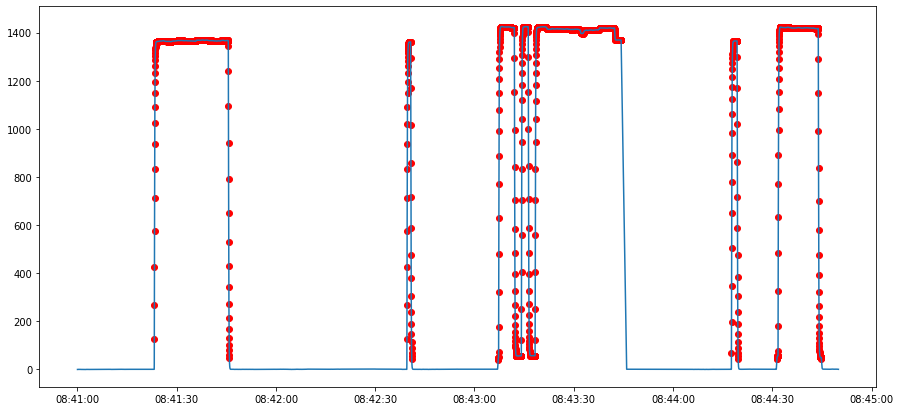

In [5]:
fig = plt.figure(figsize=[15,7])
plt.plot(df2.index,df2['pwrB'])#,df2.index,df2['rpwrB'])


cl = df2['label']==1

plt.scatter(df2.index[cl], df2['pwrB'][cl], color='red') 

In [68]:
# Read  data for PC
devid = '4353f360-98d6-11ea-8d54-4d0d5d00237b'
descriptors = 'pwrC,rpwrC,apwrC'

# first slot
# start_time = '1592584200000'
# end_time = '1592599800000'

# second slot
start_time = '1592833440000'
end_time = '1592841000000'



address = "http://52.77.235.183:8080"

r = requests.post(address + "/api/auth/login",
                  json={'username': 'tenant@thingsboard.org', 'password': 'tenant'}).json()

acc_token = 'Bearer' + ' ' + r['token']

#     df = read_data(devid, acc_token, address, str(start_time[i]), str(end_time[i]), descriptors)  

timediff = int(end_time[0])-int(start_time[0])

# if difference between end and start time is greater than 15 minutes, split data 

df = pd.DataFrame([])
svec = np.arange(int(start_time),int(end_time),3600000)
for st in svec:
    print('Another hour...')
    en = st+3600000-1

    if int(end_time)-en<=0: en = int(end_time)
#         print('start and end of iteration:',st,en)

    tmp = read_data(devid, acc_token, address, str(st), str(en), descriptors)
    if not tmp.empty:
        df = pd.concat([df,tmp])

        
df['ts'] = pd.to_datetime(df.index,utc=True, unit='ms')
df['ts'] = df['ts'].dt.tz_convert('Europe/Athens')

df.set_index('ts',inplace=True, drop=True)

df.head()

Another hour...
Another hour...
Another hour...


,pwrC,rpwrC,apwrC
ts,,,
2020-06-22 16:44:00.018000+03:00,36.3253,-109.7900,115.4319
2020-06-22 16:44:00.038000+03:00,35.9290,-109.8545,115.3493
2020-06-22 16:44:00.058000+03:00,35.4667,-109.8813,115.2007
2020-06-22 16:44:00.078000+03:00,35.0209,-110.2956,115.0356
2020-06-22 16:44:00.098000+03:00,34.6576,-109.2859,114.8375


In [67]:
df2 = df.copy()
df2 = df2.reset_index(drop=False)

df2['label']=0
df2 = df2[['ts','pwrC','apwrC','rpwrC','label']]

df2.set_index('ts', inplace=True, drop=True)

for col in ['pwrC','apwrC','rpwrC']:
    df2[col] = df2[col] - np.mean(df2[col].iloc[-40:])
    
df2.loc[df2['pwrC']>40,'label']=1
# df2.to_csv('../../Desktop/windowsshare/stelios_data/plug_data/PC.csv')

In [70]:
df3 = df.copy()
df3 = df3.reset_index(drop=False)

df3['label']=0
df3 = df3[['ts','pwrC','apwrC','rpwrC','label']]

df3.set_index('ts', inplace=True, drop=True)

for col in ['pwrC','apwrC','rpwrC']:
    df3[col] = df3[col] - np.mean(df3[col].iloc[-40:])
    
df3.loc[df3['pwrC']>40,'label']=1
# df2.to_csv('../../Desktop/windowsshare/stelios_data/plug_data/PC.csv')
df3.head()

,pwrC,apwrC,rpwrC,label
ts,,,,
2020-06-22 16:44:00.018000+03:00,3.543782,3.336977,-2.941545,0
2020-06-22 16:44:00.038000+03:00,3.147483,3.254377,-3.006045,0
2020-06-22 16:44:00.058000+03:00,2.685183,3.105777,-3.032845,0
2020-06-22 16:44:00.078000+03:00,2.239382,2.940677,-3.447145,0
2020-06-22 16:44:00.098000+03:00,1.876083,2.742577,-2.437445,0


In [71]:
df2 = pd.concat([df2,df3])
# df2.reset_index(inplace=True,drop=True)
df2.sort_index(inplace=True)
df2.reset_index(inplace=True)
df2.head()

,ts,pwrC,apwrC,rpwrC,label
0,2020-06-19 19:30:00.017000+03:00,-6.29664,-3.239937,2.009885,0
1,2020-06-19 19:30:00.037000+03:00,-6.19754,-3.239937,1.531285,0
2,2020-06-19 19:30:00.057000+03:00,-6.16454,-3.239937,1.457885,0
3,2020-06-19 19:30:00.077000+03:00,-6.09854,-3.256437,1.904485,0
4,2020-06-19 19:30:00.097000+03:00,-6.06554,-3.273038,1.764085,0


In [73]:
df2.to_csv('../../Desktop/windowsshare/stelios_data/plug_data/PC.csv')

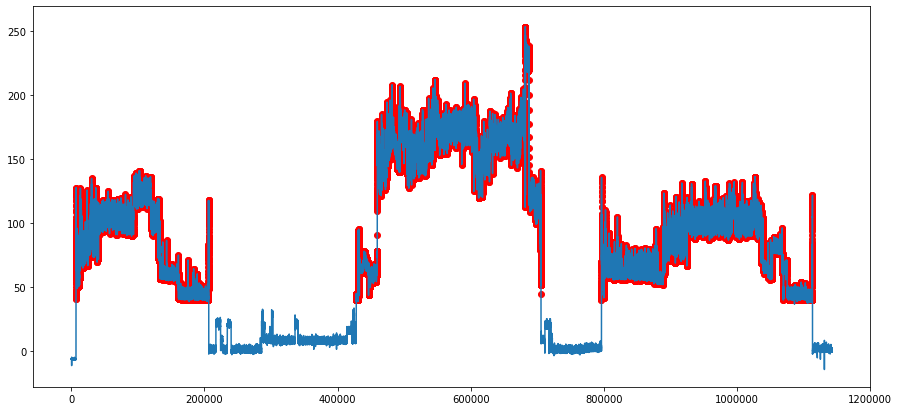

In [72]:
fig = plt.figure(figsize=[15,7])
plt.plot(df2.index,df2['pwrC'])#,df2.index,df2['rpwrB'])


cl = df2['label']==1

plt.scatter(df2.index[cl], df2['pwrC'][cl], color='red') 